In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 30
%matplotlib inline  

In [2]:
import cv2
import numpy as np

In [3]:
from infer_demo import KeyPointModel

In [4]:
ckpt=r'/home/chiebotgpuhq/MyCode/python/pytorch/KP2D/data/models/kp2d/v4.ckpt'

In [5]:
image_list=[
    r'/home/chiebotgpuhq/pic/cat1.jpeg',
    r'/home/chiebotgpuhq/pic/cat1_2.jpeg',
]

In [6]:
def plt_show(img_path):
    img=mpimg.imread(img_path)
    plt.imshow(img)

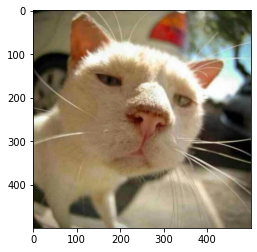

In [7]:
plt_show(image_list[0])

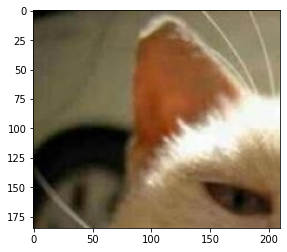

In [8]:
plt_show(image_list[1])

In [9]:
def get_kp(im1_path,im2_path,features_type='orb'):
    im1=cv2.imread(im1_path,cv2.IMREAD_COLOR)
    im2=cv2.imread(im2_path,cv2.IMREAD_COLOR)

    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    if 'orb'==features_type:
    # Detect ORB features and compute descriptors.
        detector = cv2.ORB_create(1000)
    elif 'sift'==features_type:
        detector = cv2.SIFT_create(1000)
    else:
        raise ValueError()
    keypoints1, descriptors1 = detector.detectAndCompute(im1Gray, None)
    kp1_array= np.array([list(kp.pt) for kp in keypoints1])
    keypoints2, descriptors2 = detector.detectAndCompute(im2Gray, None)
    kp2_array= np.array([list(kp.pt) for kp in keypoints2])
    return kp1_array, descriptors1,kp2_array,descriptors2

In [10]:
import  cv2

class Homographier(object):
    def __init__(self,):
        self.matcher=cv2.BFMatcher(cv2.NORM_L2,crossCheck=True)

    def __call__(self,kp_1,desc1,kp_2,desc2):
        """
            Args:
                kp_1: numpy.ndarray
                    (N,2)
        """
        if desc1.shape[0]<4 and desc2.shape[0]<4:
            return np.array([[1,0,0],[0,1,0],[0,0,1]])
        matches = self.matcher.match(desc1,desc2)

        matches_idx = np.array([m.queryIdx for m in matches])
        m_keypoints =kp_1[matches_idx, :]
        matches_idx = np.array([m.trainIdx for m in matches])
        m_warped_keypoints = kp_2[matches_idx, :]
        print(m_keypoints.shape,m_warped_keypoints.shape)
        H, _ = cv2.findHomography(m_keypoints[:, :2],
                                m_warped_keypoints[:, :2], cv2.RANSAC, 3, maxIters=5000)
        if H is None:
            return np.array([[1,0,0],[0,1,0],[0,0,1]])
        return H
    
matcher=Homographier()

## 使用ORB特征

In [11]:
kp1_o,d1_o,kp2_o,d2_o=get_kp(*image_list,features_type='orb')

In [12]:
H=matcher(kp1_o,d1_o,kp2_o,d2_o)

(115, 2) (115, 2)


In [13]:
print(np.array2string(H,precision=3,separator=',',suppress_small=True))

[[ 0.989,-0.012, 1.841],
 [-0.003, 0.986, 1.048],
 [-0.   ,-0.   , 1.   ]]


## 使用SIFT

In [14]:
kp1_o,d1_o,kp2_o,d2_o=get_kp(*image_list,features_type='sift')
print(kp1_o.shape)
print(kp2_o.shape)

(480, 2)
(84, 2)


In [15]:
H=matcher(kp1_o,d1_o,kp2_o,d2_o)

(81, 2) (81, 2)


In [16]:
print(np.array2string(H,precision=3,separator=',',suppress_small=True))

[[ 0.998,-0.001, 0.189],
 [ 0.   , 0.999,-0.016],
 [-0.   ,-0.   , 1.   ]]


##  使用kpnet

In [17]:
model=KeyPointModel(ckpt)

Loaded KeypointNet from /home/chiebotgpuhq/MyCode/python/pytorch/KP2D/data/models/kp2d/v4.ckpt
KeypointNet params descriptor_loss: True
do_cross: True
do_upsample: True
use_color: True
with_io: True


In [18]:
kp_result=model(*image_list)
print(kp_result[0].shape,kp_result[2].shape)
H=matcher(*kp_result)

(1000, 2) (495, 2)
(77, 2) (77, 2)


In [19]:
print(np.array2string(H,precision=3,separator=',',suppress_small=True))

[[-0.015,-0.142,87.984],
 [-0.025,-0.008,23.925],
 [-0.001,-0.002, 1.   ]]
